<a href="https://colab.research.google.com/github/sarbol/NumericalReasoningModels/blob/main/ConFinQA_LLModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets sentence-transformers umap-learn hdbscan keybert

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 61.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from keybert import KeyBERT
import plotly.express as px

In [ ]:
import os
import torch
import numpy as np
import json
import glob
import random
import tqdm
import spacy
import requests
import pickle
from google.colab import userdata
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"
OPENROUTER_API_KEY = userdata.get("OPENROUTER_APPKEY")

In [ ]:
def llm_cluster_annotation(model_name: str, provider: str, prompt: str):
  headers = {
      "Authorization": f"Bearer {OPENROUTER_API_KEY}",
      "Content-Type": "application/json",
      }

  response = requests.post(
      url = OPENROUTER_URL,
      headers = headers,
      data=json.dumps({
          "model": "deepseek/deepseek-chat:free",
          "messages": [
              {
                  "role": "user",
                  "content": prompt
                  }
              ],
          "provider": {
              "order": [provider]
              }
          })
      )
  if response.status_code == 200:
    result = response.json()
    if result:
      print(result.get("choices")[0]["message"]["content"])
  else:
    print(f"Error: {response.status_code}")

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 42
set_seed(SEED)

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
BASE_DIR = "/content/drive/MyDrive/bbc/"

In [ ]:
model_weight = {
    "mpnet": "all-mpnet-base-v2",
    "qwen": "Qwen/Qwen3-Embedding-0.6B"
}

In [ ]:
embedder = SentenceTransformer(model_weight["mpnet"])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def visualize_cluster_2D(reduced_embeddings, labels, title):

  plot_dict = {
      "x_dim": reduced_embeddings[:, 0],
      "y_dim": reduced_embeddings[:, 1],
      "hover_data": [str(l) for l in labels],
      "label": [str(l) for l in labels]
  }

  hover_data = {
      "hover_data": True,
      "x_dim": False,
      "y_dim": False,
      "label": False
      }


  base_colors = px.colors.qualitative.Plotly  # or "D3", "Set1", etc.
  color_map = {}

  for i, label in enumerate(set(labels)):
        if label == -1:  # noise label in HDBSCAN
            color_map["-1"] = "lightgrey"
        else:
            color_map[str(label)] = base_colors[i % len(base_colors)]

  fig = px.scatter(plot_dict, x = "x_dim", y = "y_dim", template = "seaborn",
                   title = "Embeddings", color = "label", color_discrete_map = color_map, hover_data = hover_data)

  fig.update_layout(showlegend=False)
  fig.show()

In [ ]:
def visualize_cluster_3D(reduced_embeddings, labels, title):

  plot_dict = {
      "x_dim": reduced_embeddings[:, 0],
      "y_dim": reduced_embeddings[:, 1],
      "z_dim": (reduced_embeddings[:, 2] - np.min(reduced_embeddings[:, 2])) / (np.max(reduced_embeddings[:, 2]) - np.min(reduced_embeddings[:, 2])),
      "hover_data": title,
      "label": [str(l) for l in labels]
  }

  hover_data = {
      "hover_data": True,
      "x_dim": False,
      "y_dim": False,
      "z_dim": False,
      "label": False
      }


  base_colors = px.colors.qualitative.Plotly  # or "D3", "Set1", etc.
  color_map = {}

  for i, label in enumerate(set(labels)):
        if label == -1:  # noise label in HDBSCAN
            color_map["-1"] = "lightgrey"
        else:
            color_map[str(label)] = base_colors[i % len(base_colors)]

  fig = px.scatter(plot_dict, x = "x_dim", y = "y_dim", size = "z_dim", template = "seaborn",
                   title = "Embeddings", color = "label", color_discrete_map = color_map, hover_data = hover_data)

  fig.update_layout(showlegend=False)
  fig.show()

In [ ]:
def silhouette_analysis(reduced_embeddings, labels, model_name):

  pos_mask = labels != -1

  filtered_embeddings = reduced_embeddings[pos_mask, :]

  filtered_labels = labels[pos_mask]

  n_clusters = len(set(filtered_labels))

  silhouette_avg = silhouette_score(filtered_embeddings, filtered_labels)
  sample_silhouette_values = silhouette_samples(filtered_embeddings, filtered_labels)

  min_x = np.min(sample_silhouette_values)

  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax[0].set_xlim([min_x - 0.1, 1])
  ax[0].set_ylim([0, len(filtered_labels) + (n_clusters + 1) * 10])

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[filtered_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[0].fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax[0].text((min_x - 0.1) / 2, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10
  ax[0].set_title("Clusters Silhouette Scores")
  ax[0].set_xlabel("Silhouette coefficient values")
  ax[0].set_ylabel("Cluster label")

  ax[0].axvline(x = silhouette_avg, color = "red", linestyle = "--")
  ax[0].set_yticks([])
  ax[0].set_xticks(np.append(min_x - 0.1, np.linspace(0, 1, 6)))

  colors = cm.nipy_spectral(filtered_labels.astype(float) / n_clusters)
  ax[1].scatter(
      filtered_embeddings[:, 0],
      filtered_embeddings[:, 1],
      marker=".",
      lw=0,
      alpha=0.7,
      c=colors,
      edgecolor="k",
  )

  ax[1].set_title("Clusterd Data")
  ax[1].set_xlabel("Dimension 1")
  ax[1].set_ylabel("Dimension 2")

  plt.suptitle(
      f"Silhouette analysis for {model_name} clustering on sample data with n_clusters = {n_clusters}",
      fontsize=14,
      fontweight="bold",
      )

In [ ]:
def get_category_embeddings(model: SentenceTransformer, category: str = "sport", n_dim: int = 2, output_dir: str = "/content/drive/MyDrive/bbc/output", batch_size: int = 16):

  if os.path.isfile(w:=os.path.join(output_dir, f"{category}_embeddings.npy")):
    embeddings = np.load(w)
    files = glob.glob((os.path.join(BASE_DIR, category)) + "/*.txt")
    raw_text_data = []
    for text_file in files:
      with open(text_file, "r") as f:
        raw_text = f.read()
      raw_text_data.append(raw_text)

  else:
    files = glob.glob((os.path.join(BASE_DIR, category)) + "/*.txt")
    embeddings = np.empty((0, model.get_sentence_embedding_dimension()))
    raw_text_data = []
    for i in tqdm.tqdm(range(0, len(files), batch_size)):
      data = []
      for text_file in files[i:i+batch_size]:
        with open(text_file, "r") as f:
          raw_text = f.read()
        data.append(raw_text)
      embeddings = np.concatenate([embeddings, model.encode(data, batch_size=batch_size)])
      raw_text_data.extend(data)
    np.save(w, embeddings)

  reducer = umap.UMAP(n_components = n_dim, n_neighbors = 10, min_dist = 0.10, random_state=SEED)
  reduced_embeddings = reducer.fit_transform(embeddings)

  with open(os.path.join(output_dir, f"{category}_reducer.pkl"), "wb") as f:
    pickle.dump(reducer, f)

  return reduced_embeddings, raw_text_data

In [ ]:
def get_cluster_labels(reduced_embeddings: np.ndarray, min_clusters: int = 5, kmeans: bool = True):
  if kmeans:
    kmeans_cluster = KMeans(n_clusters = min_clusters)
    k_labels = kmeans_cluster.fit_predict(reduced_embeddings)
  else:
    hdb = hdbscan.HDBSCAN(min_cluster_size = min_clusters, prediction_data = True)
    k_labels = hdb.fit_predict(reduced_embeddings)
  return k_labels

In [ ]:
def cluster_analysis(reduced_embeddings: np.ndarray, clusters: range, kmeans: bool = True):
  scores = []
  categories = []
  min_clusters = []
  for k in clusters:
    if kmeans:
      labels = get_cluster_labels(reduced_embeddings, min_clusters = k)
      score = silhouette_score(reduced_embeddings, labels)
      categories.append(k)
      scores.append(score)
      min_clusters.append(k)
    else:
      labels = get_cluster_labels(reduced_embeddings, min_clusters = k, kmeans = False)
      filtered_embeddings = reduced_embeddings[labels != -1, :]
      filtered_labels = labels[labels != -1]
      score = silhouette_score(filtered_embeddings, filtered_labels)
      if (w:=len(np.unique(filtered_labels))) in categories:
        scores[categories.index(w)] = max(score, scores[categories.index(w)])
        min_clusters[categories.index(w)] = k if score > scores[categories.index(w)] else min_clusters[categories.index(w)]
      else:
        categories.append(w)
        scores.append(score)
        min_clusters.append(k)

  indices = np.argsort(categories)
  categories = sorted(categories)
  scores = [round(scores[i], 1) for i in indices]
  min_cluster = [min_clusters[i] for i in indices]

  max_score, cat, min_cluster = max(scores), categories[np.argmax(scores)], min_cluster[np.argmax(scores)]

  plt.plot(categories, scores)
  plt.title(f"Score: {round(max_score, 2)}\n categories: {cat}\n min_cluster: {min_cluster}")
  plt.show()

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
class ClustersEntities:
  def __init__(self, raw_text: list, labels: np.ndarray):
    self.text = raw_text
    self.labels = labels
    self.unique_label_ents = dict()

  def text_to_entity(self, entity_labels: list):
    text = np.array(self.text)[self.labels != -1]
    labels = self.labels[self.labels != -1]
    label_ents = dict()
    for k in np.unique(labels).tolist():
      label_ents[k] = self.__spacy_entities("\n".join(text[labels == k]), entity_labels = entity_labels)
    for label in label_ents:
      other_ents = []
      for k, v in label_ents.items():
        if k != label:
          other_ents.extend(v)
      exclusive_ents = set(label_ents[label]).difference(other_ents)
      self.unique_label_ents[label] = [ent for ent in label_ents[label] if ent in exclusive_ents]
    # Filter out labels with no unique entities
    self.unique_label_ents = {k: v for k, v in self.unique_label_ents.items() if v}
    return True

  def visualize_cluster(self, entity_labels: list):
    if not self.text_to_entity(entity_labels):
      return None
    ent_dict = self.unique_label_ents
    w = len(ent_dict)
    if w == 0: # Handle the case where there are no unique entities
        print("No unique entities found for any cluster.")
        return
    rows = w // 3 + (w % 3 > 0) # Calculate rows needed, adding an extra row if there's a remainder
    if rows == 1:
      fig, ax = plt.subplots(1, w, figsize = (25, 18))
      # Ensure ax is always an array for consistent indexing
      if w == 1:
        ax = [ax]
      for i, label in enumerate(ent_dict):
        wordcloud = WordCloud(max_words=200, background_color="white").generate(" ".join(ent_dict[label]))
        ax[i].imshow(wordcloud, interpolation="bilinear")
        ax[i].set_title(f"Cluster {label}")
        ax[i].axis("off")
    else:
      fig, ax = plt.subplots(rows, 3, figsize = (25, 18))
      # Flatten the axes array for easier iteration
      ax_flat = ax.flatten()
      for i, label in enumerate(ent_dict):
        wordcloud = WordCloud(max_words=200, background_color="white").generate(" ".join(ent_dict[label]))
        ax_flat[i].imshow(wordcloud, interpolation="bilinear")
        ax_flat[i].set_title(f"Cluster {label}")
        ax_flat[i].axis("off")

      # Hide any unused subplots
      for j in range(w, rows * 3):
        fig.delaxes(ax_flat[j])
    plt.show()


  @staticmethod
  def __spacy_entities(text: str, entity_labels: list):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in entity_labels]

# SPORT

In [ ]:
embeds, raw_text = get_category_embeddings(embedder, category = "sport", n_dim = 3, batch_size = 16)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


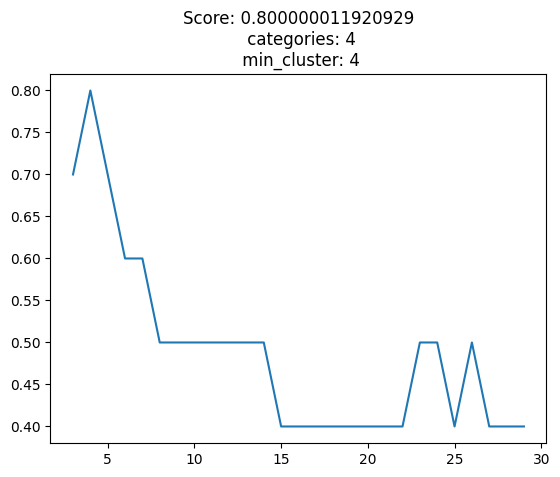

In [ ]:
cluster_analysis(embeds, range(3, 30))

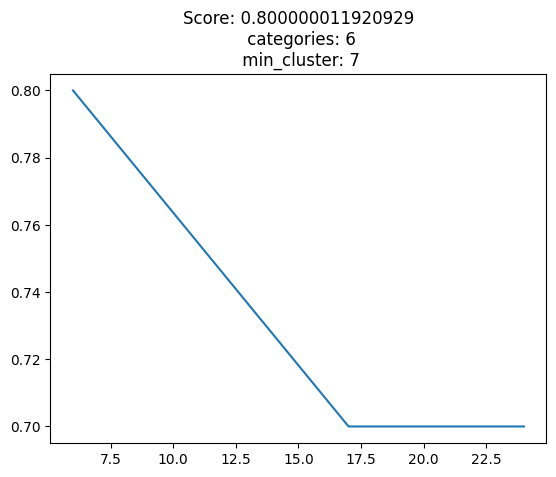

In [ ]:
cluster_analysis(embeds, range(3, 10), kmeans = False)

In [ ]:
kmeans = True
if kmeans:
  clusterer = KMeans(n_clusters = 5)
else:
  clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, prediction_data = True)

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=int32)

In [ ]:
f"{round(len(labels[labels == -1]) * 100 / len(labels), 2)}%"

'0.0%'

In [ ]:
visualize_cluster_3D(embeds, labels, labels)

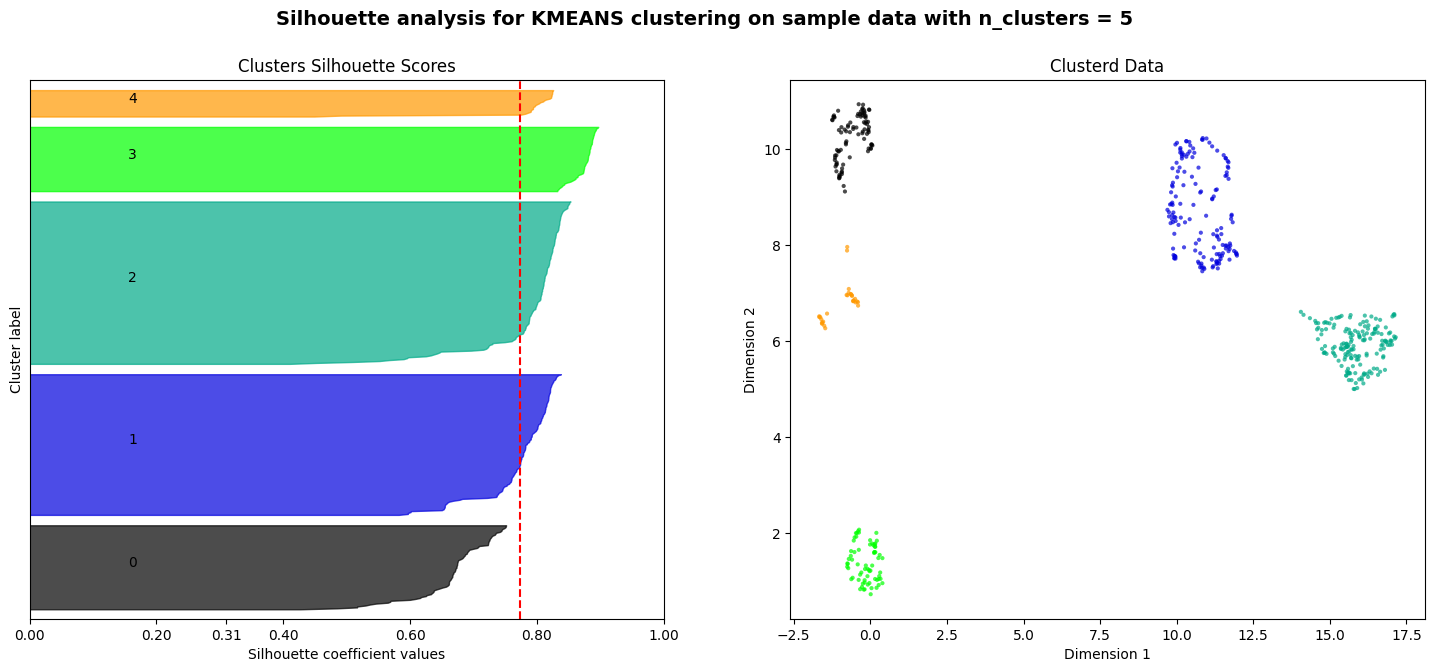

In [ ]:
silhouette_analysis(embeds, labels, "KMEANS")

In [ ]:
ce = ClustersEntities(raw_text, labels)

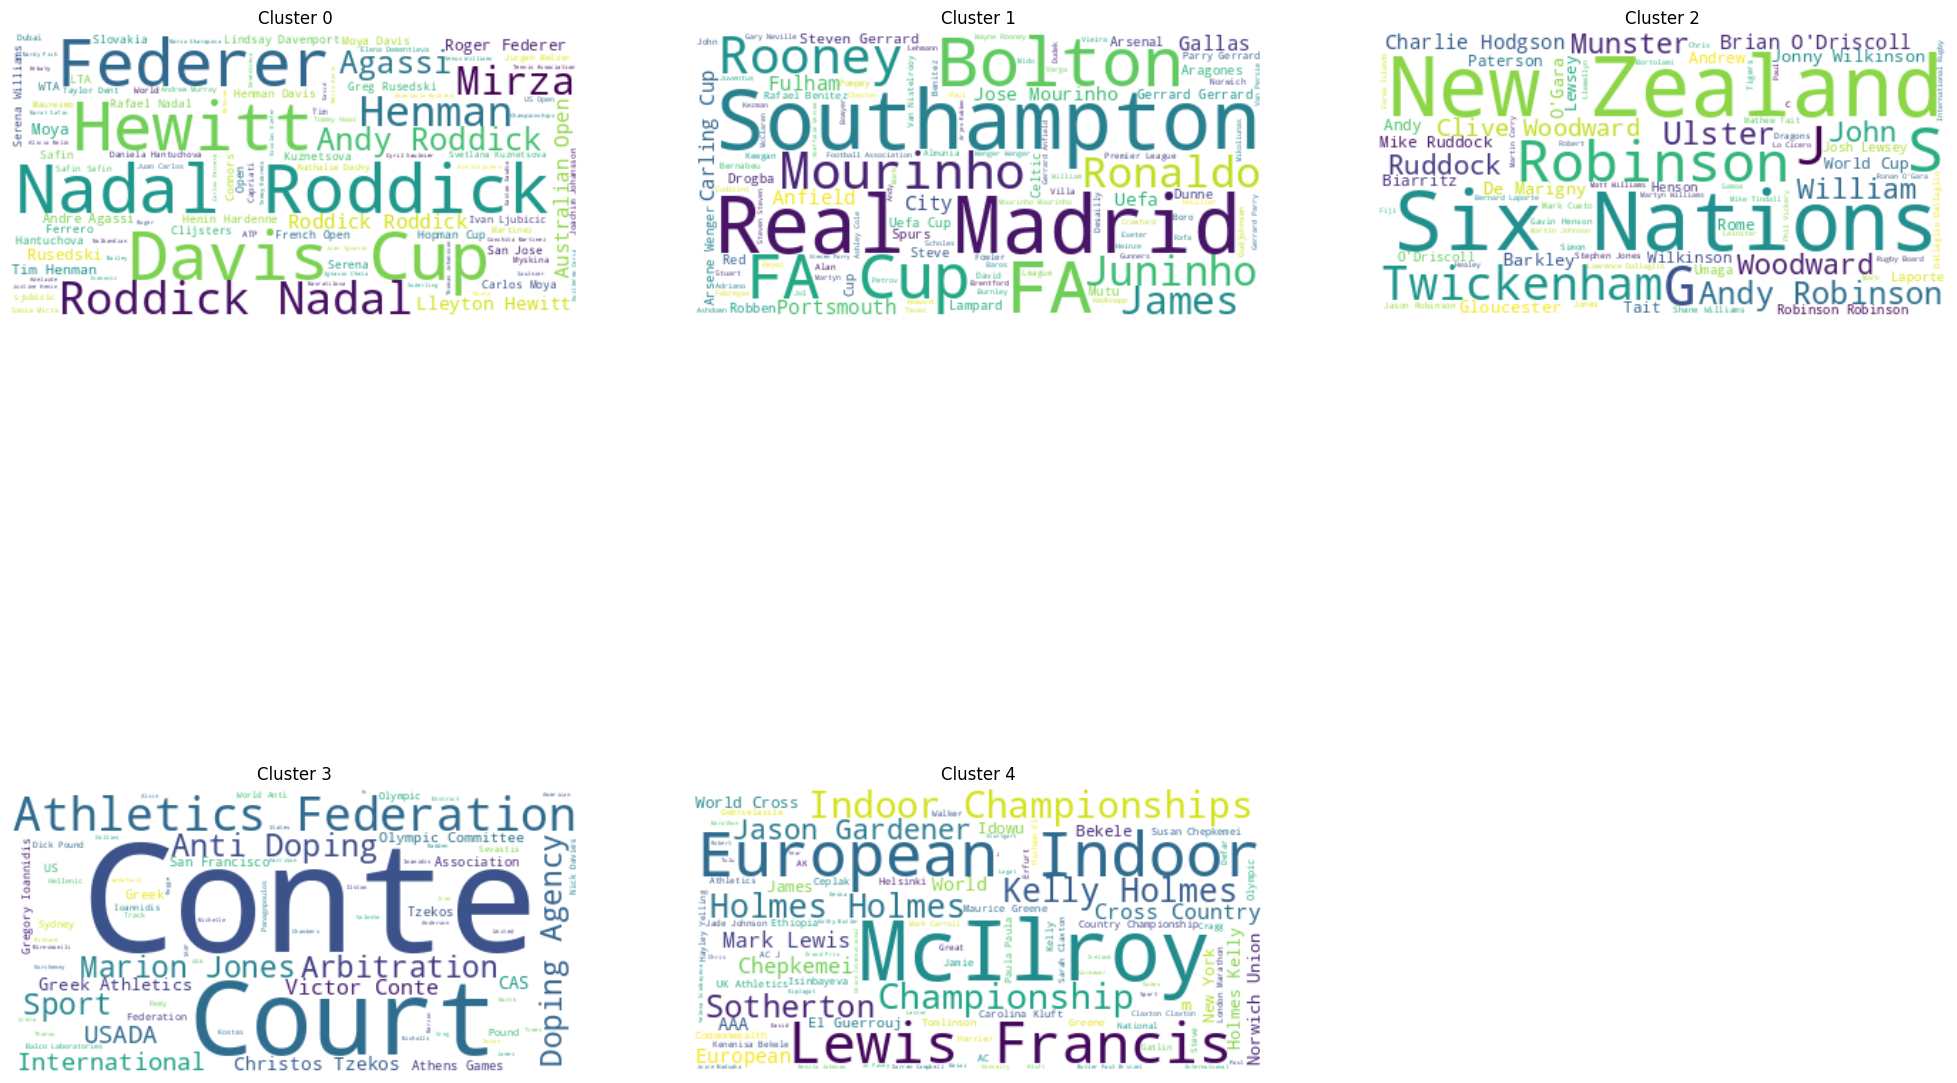

In [ ]:
ce.visualize_cluster(entity_labels = ["PERSON", "ORG", "EVENT", "GPE"])

In [ ]:
cat_dict = {f"cluster_{k}":" ".join(set(v)) for k, v in ce.unique_label_ents.items()}

In [ ]:
prompt = f"""
Give these categories appropriate labels
{cat_dict}

Return a JSON
"""

In [ ]:
headers = {
    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
    "Content-Type": "application/json",
}

In [ ]:
# list(set(zero_ent.split()))

In [ ]:
response = requests.post(
  url = OPENROUTER_URL,
  headers = headers,
  data=json.dumps({
    "model": "deepseek/deepseek-chat:free",
    "messages": [
      {
        "role": "user",
        "content": prompt
      }
    ],
    "provider": {
        "order": ["Targon"]
    }
  })
)

In [ ]:
if response.status_code == 200:
  result = response.json()
  print(result.get("choices")[0]["message"]["content"])

Here is a JSON structure with appropriate labels for the given clusters based on their content:

```json
{
    "cluster_0": "Tennis Players, Tournaments, and Events",
    "cluster_1": "Football (Soccer) Players, Teams, and Events",
    "cluster_2": "Rugby Players, Teams, and Events",
    "cluster_3": "Olympic Sports and Doping Controversies",
    "cluster_4": "Athletics and Track & Field Events"
}
``` 

This labeling reflects the dominant themes in each cluster:  
1. **Cluster 0**: Focuses on tennis players, tournaments, and related events.  
2. **Cluster 1**: Centered around football (soccer) players, teams, and associated events.  
3. **Cluster 2**: Pertains to rugby players, teams, and events.  
4. **Cluster 3**: Deals with Olympic sports and doping-related controversies.  
5. **Cluster 4**: Focuses on athletics and track & field events, including athletes and competitions.


In [ ]:
clusterer

HDBSCAN(min_cluster_size=8, prediction_data=True)

In [ ]:
%%time
instance_vector = embedder.encode(["Manchester United has been knocked out by Juventus in the semi-final of the Champions League. Their unbeaten run came to a close after suffering a 3-0 defeat at the hand of the Azurris"])

CPU times: user 431 ms, sys: 92.1 ms, total: 523 ms
Wall time: 1.45 s


In [ ]:
with open("/content/drive/MyDrive/bbc/output/sport_reducer.pkl", "rb") as f:
  sport_reducer = pickle.load(f)

In [ ]:
%%time
sport_embeds = sport_reducer.transform(instance_vector)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 11.7 ms


In [ ]:
sport_embeds.reshape(1, 1, 3)

array([[[10.728114 ,  4.848075 ,  2.8403144]]], dtype=float32)

In [ ]:
instance_label, instance_prob = hdbscan.approximate_predict(clusterer, sport_embeds)

In [ ]:
instance_label, instance_prob

(array([1], dtype=int32), array([0.99365387]))

In [ ]:
sport_inference_object = {
    "dimension_reducer": sport_reducer,
    "clustering_algorithm": clusterer,
    "labels": {
        "0": "Tennis",
        "1": "Football",
        "2": "Rugby",
        "3": "Olympic Sports and Doping Controversies",
        "4": "Athletics/Track & Field"
    }
}

In [ ]:
with open("/content/drive/MyDrive/bbc/output/sport_inference_object.pkl", "wb") as f:
  pickle.dump(sport_inference_object, f)

# TECHNOLOGY

In [ ]:
embeds, raw_text = get_category_embeddings(embedder, category = "tech", n_dim = 3, batch_size = 16)

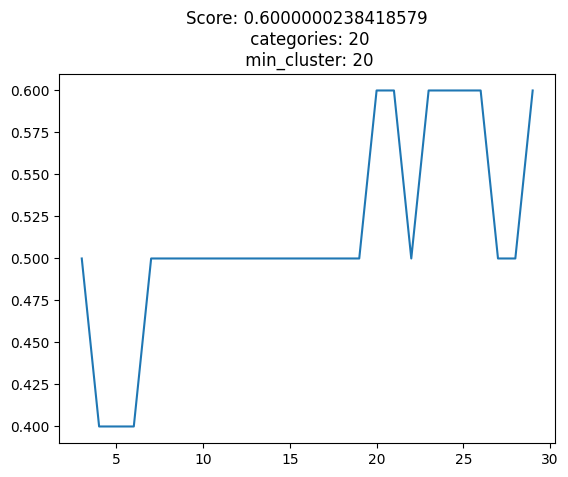

In [ ]:
cluster_analysis(embeds, range(3, 30))

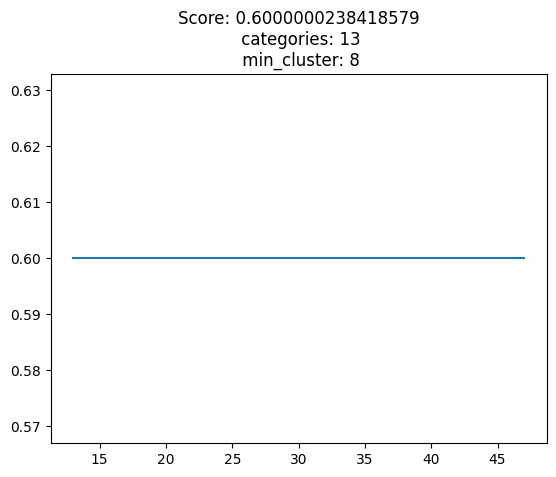

In [ ]:
cluster_analysis(embeds, range(3, 10), kmeans = False)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 8, prediction_data = True)

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
f"{round(len(labels[labels == -1]) * 100 / len(labels), 2)}%"

'15.71%'

In [ ]:
visualize_cluster_3D(embeds, labels, labels)

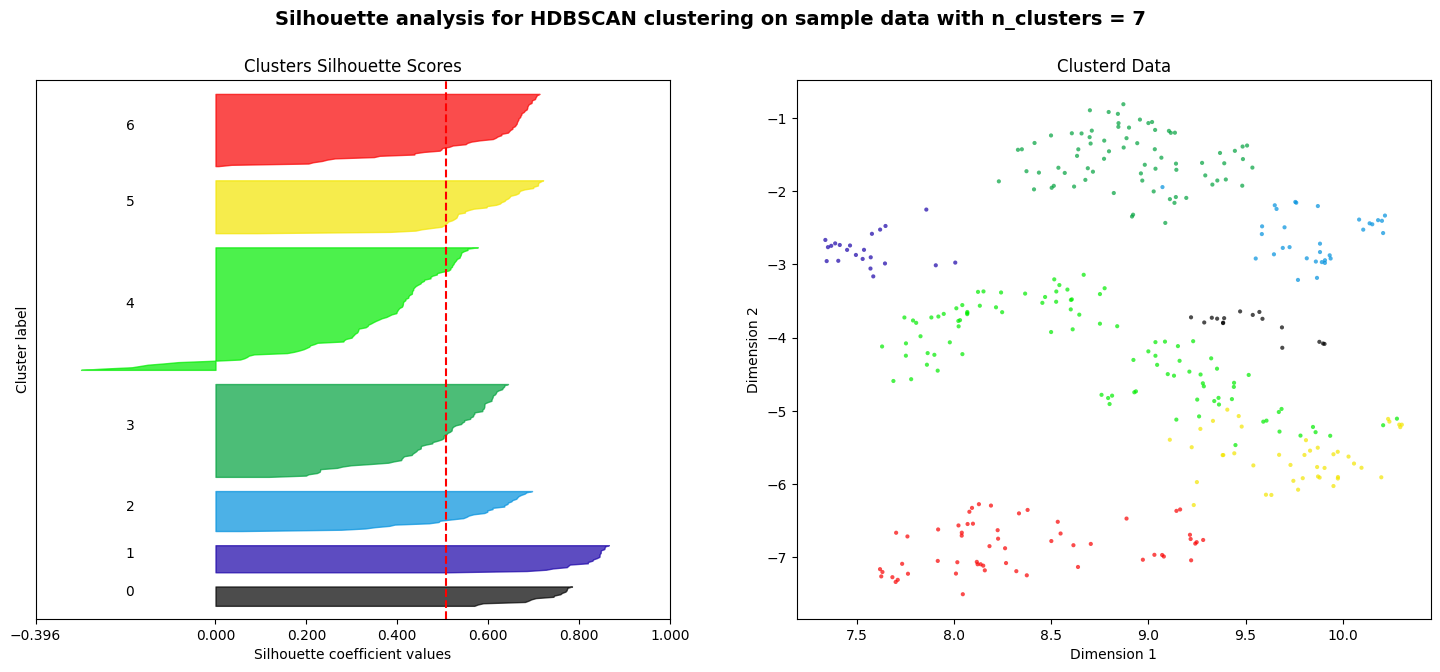

In [ ]:
silhouette_analysis(embeds, labels, "HDBSCAN")

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
pd.Series(labels).value_counts()

4    96
 3    73
-1    63
 6    57
 5    42
 2    32
 1    22
 0    16
Name: count, dtype: int64

In [ ]:
ce = ClustersEntities(raw_text, labels)

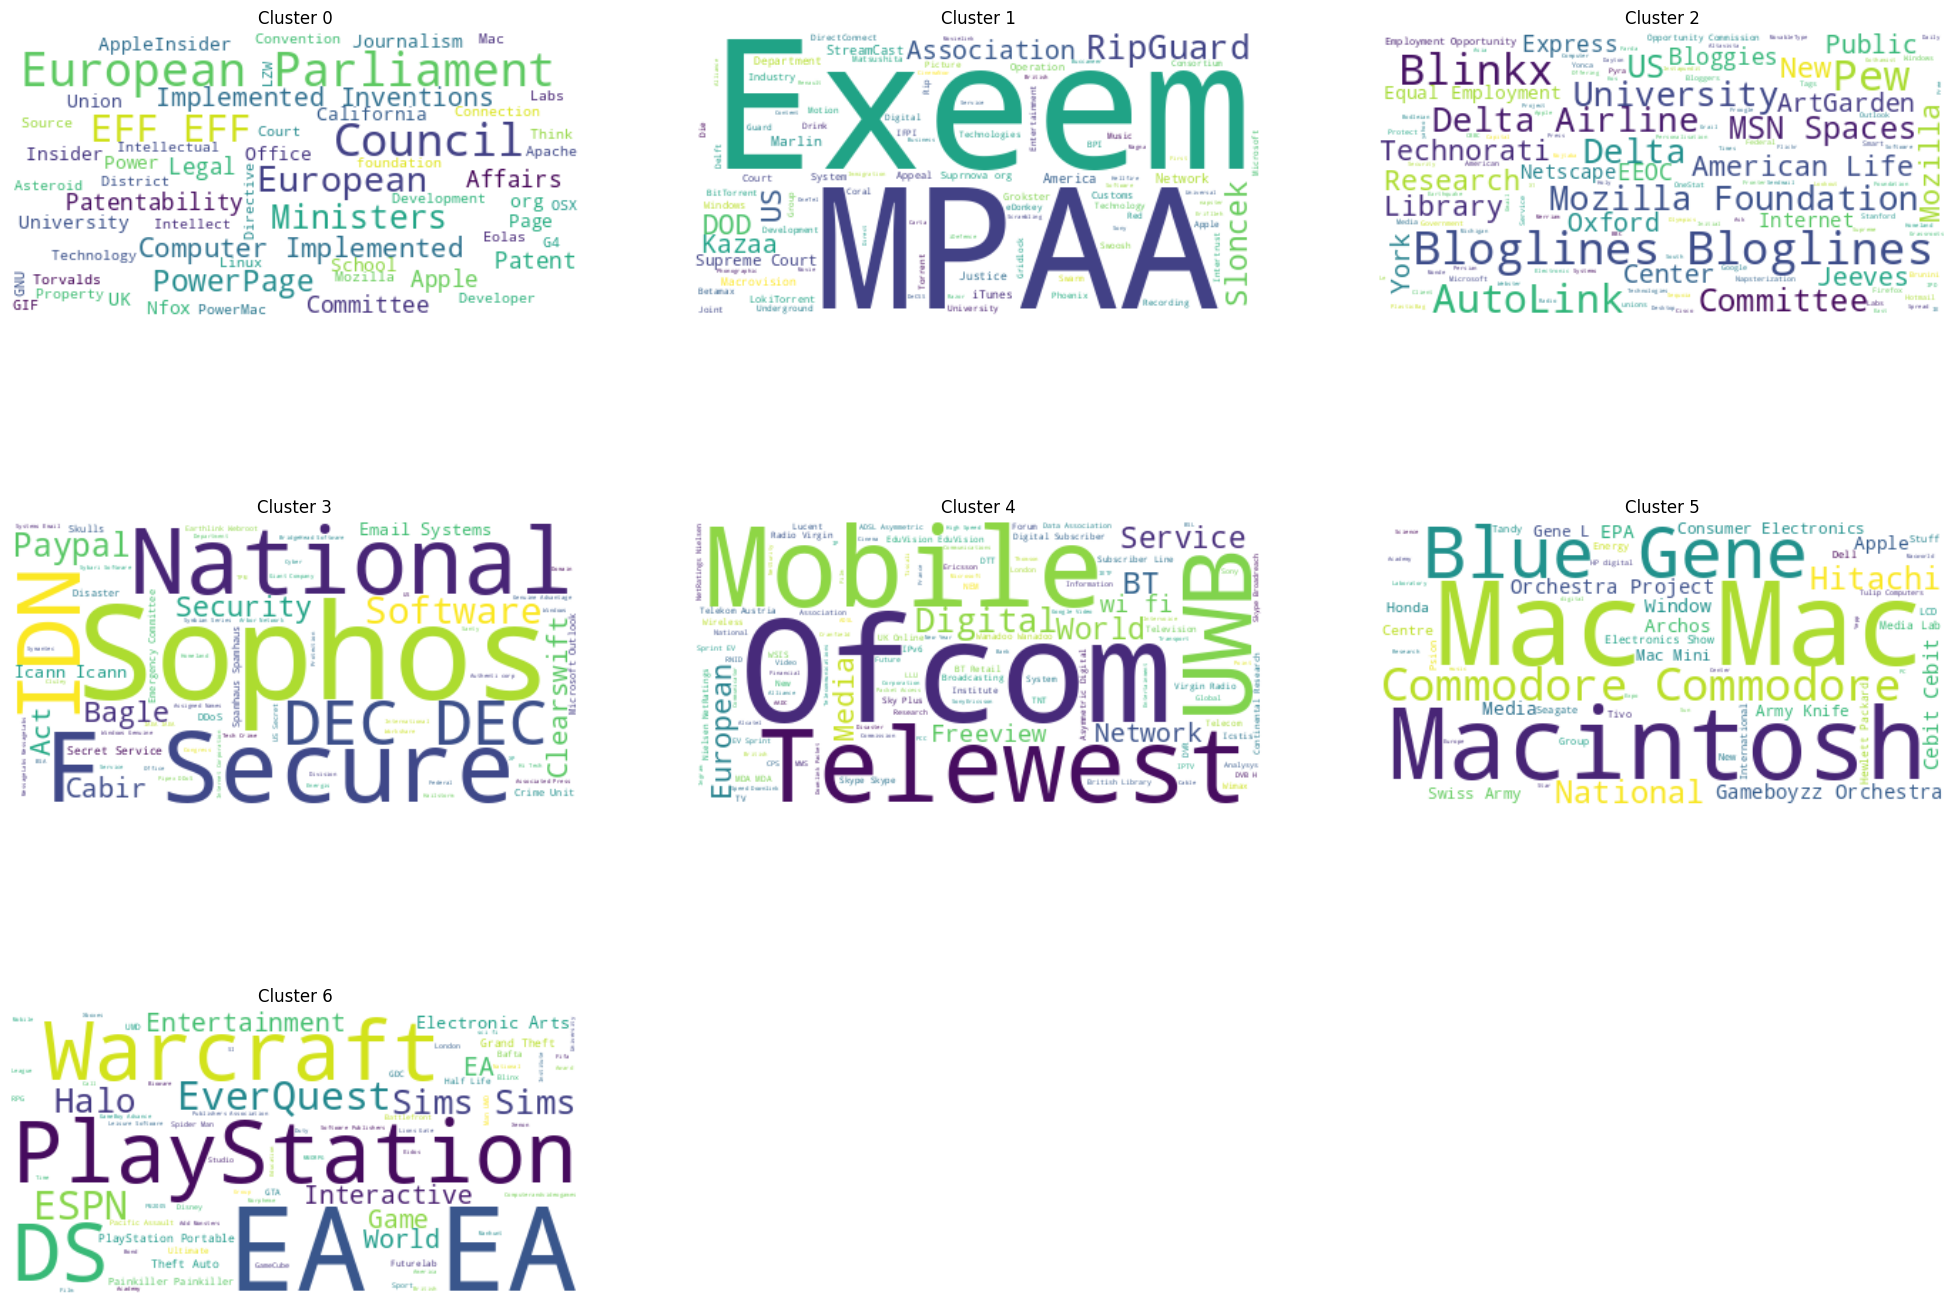

In [ ]:
ce.visualize_cluster(entity_labels = ["PRODUCT", "ORG", "EVENT"])

In [ ]:
cat_dict = {f"cluster_{k}":" ".join(set(v)) for k, v in ce.unique_label_ents.items()}

In [ ]:
prompt = f"""
Give these categories appropriate labels
{cat_dict}

Return a JSON
"""

In [ ]:
llm_cluster_annotation("deepseek/deepseek-chat:free", "Targon", prompt)

```json
{
  "cluster_0": "Technology and Intellectual Property Legal Affairs",
  "cluster_1": "Digital Piracy and Copyright Enforcement",
  "cluster_2": "Internet and Technology News",
  "cluster_3": "Cybersecurity and Online Threats",
  "cluster_4": "Media and Telecommunications",
  "cluster_5": "Consumer Electronics and Technology Innovations",
  "cluster_6": "Video Games and Interactive Entertainment"
}
```


In [ ]:
with open("/content/drive/MyDrive/bbc/output/tech_reducer.pkl", "rb") as f:
  tech_reducer = pickle.load(f)

In [ ]:
tech_reducer

UMAP(n_components=3, n_jobs=1, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
tech_inference_object = {
    "dimension_reducer": tech_reducer,
    "clustering_algorithm": clusterer,
    "labels": {
        "0": "Intellectual Property & Tech Legislations",
        "1": "Digital Piracy and Copyright Enforcement",
        "2": "Internet Technology",
        "3": "Cybersecurity and Online Threats",
        "4": "Media and Telecommunications",
        "5": "Consumer Electronics and Tech Hardware",
        "6": "Video Games and Interactive Entertainment"
    }
}

In [ ]:
with open("/content/drive/MyDrive/bbc/output/tech_inference_object.pkl", "wb") as f:
  pickle.dump(tech_inference_object, f)

# ENTERTAINMENT

In [ ]:
embeds, raw_text = get_category_embeddings(embedder, category = "entertainment", n_dim = 3, batch_size = 16)

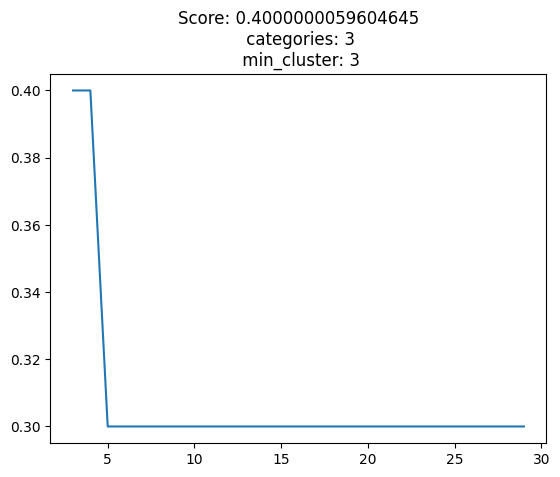

In [ ]:
cluster_analysis(embeds, range(3, 30))

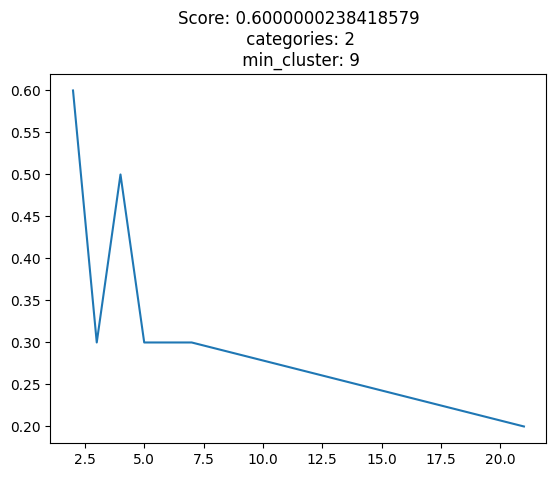

In [ ]:
cluster_analysis(embeds, range(3, 30), kmeans = False)

In [ ]:
kmeans = True
if kmeans:
  clusterer = KMeans(n_clusters = 3)
else:
  clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, prediction_data = True)

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

In [ ]:
f"{round(len(labels[labels == -1]) * 100 / len(labels), 2)}%"

'0.0%'

In [ ]:
visualize_cluster_3D(embeds, labels, labels)

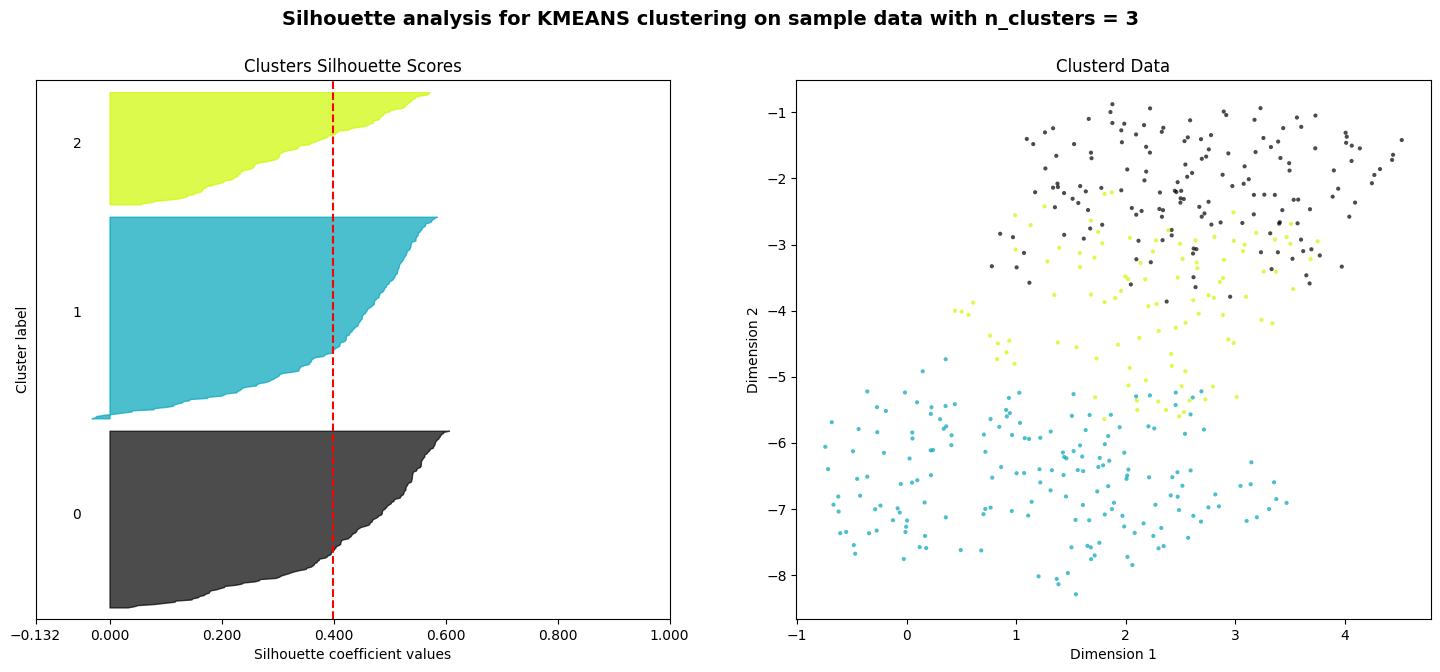

In [ ]:
silhouette_analysis(embeds, labels, "KMEANS")

In [ ]:
ce = ClustersEntities(raw_text, labels)

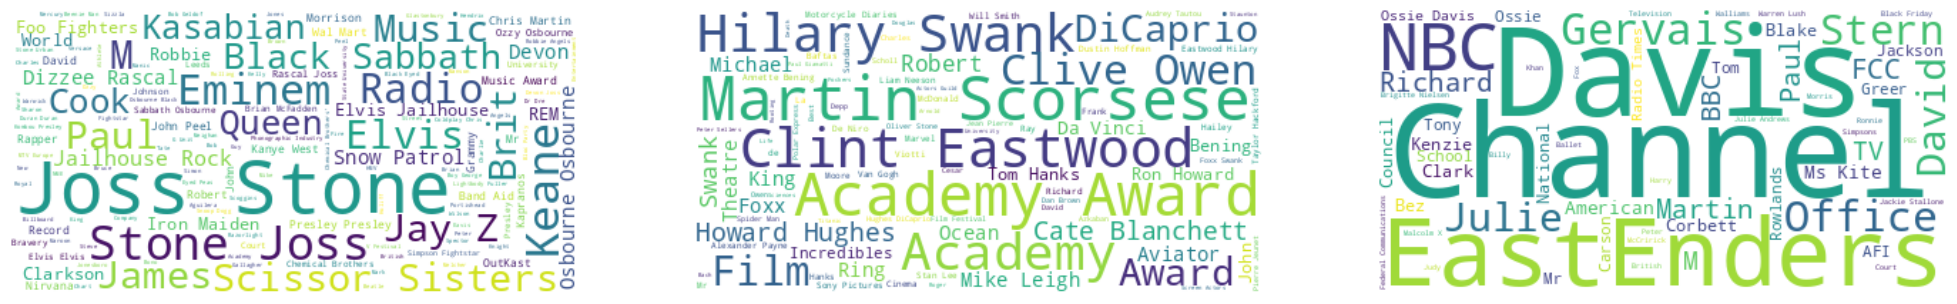

In [ ]:
ce.visualize_cluster(entity_labels = ["PERSON", "ORG", "EVENT"])

In [ ]:
cat_dict = {f"cluster_{k}":" ".join(set(v)) for k, v in ce.unique_label_ents.items()}

In [ ]:
prompt = f"""
Give these categories appropriate labels
{cat_dict}

Return a JSON
"""

In [ ]:
llm_cluster_annotation("deepseek/deepseek-chat:free", "Targon", prompt)

```json
{
  "cluster_0": "Music and Entertainment",
  "cluster_1": "Film and Cinema",
  "cluster_2": "Television and Media"
}
```


In [ ]:
pd.Series(labels).value_counts()

1    179
0    157
2    100
Name: count, dtype: int64

In [ ]:
clusterer

KMeans(n_clusters=3)

In [ ]:
with open("/content/drive/MyDrive/bbc/output/entertainment_reducer.pkl", "rb") as f:
  entertainment_reducer = pickle.load(f)

In [ ]:
entertainment_inference_object = {
    "dimension_reducer": entertainment_reducer,
    "clustering_algorithm": clusterer,
    "labels": {
        "0": "Music",
        "1": "Film and Cinema",
        "2": "Television and Media",
    }
}

In [ ]:
with open("/content/drive/MyDrive/bbc/output/entertainment_inference_object.pkl", "wb") as f:
  pickle.dump(entertainment_inference_object, f)

# POLITICS

In [ ]:
embeds, raw_text = get_category_embeddings(embedder, category = "politics", n_dim = 3, batch_size = 50)

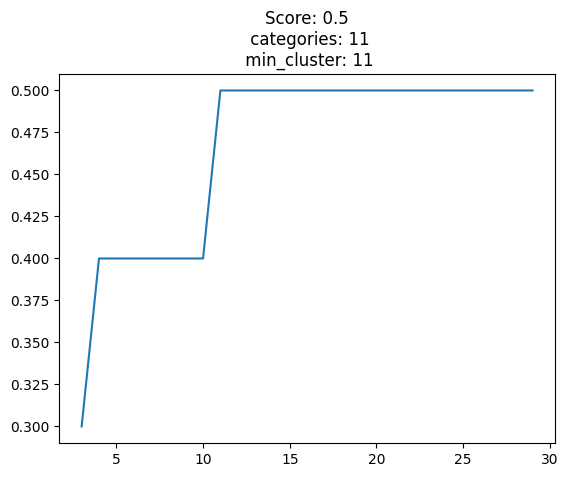

In [ ]:
cluster_analysis(embeds, range(3, 30))

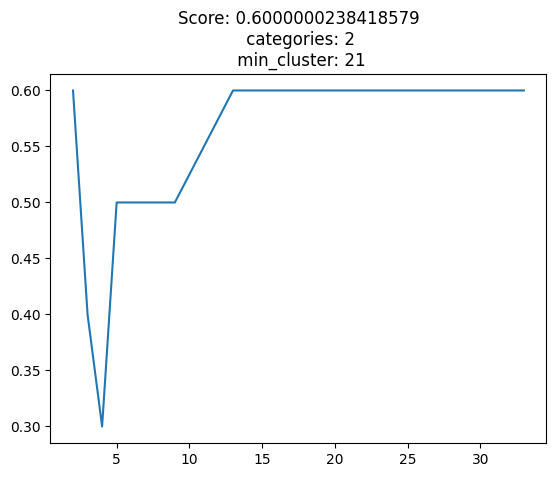

In [ ]:
cluster_analysis(embeds, range(3, 30), kmeans = False)

In [ ]:
kmeans = False
if kmeans:
  clusterer = KMeans(n_clusters = 11)
else:
  clusterer = hdbscan.HDBSCAN(min_cluster_size = 11, prediction_data = True)

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [ ]:
f"{round(len(labels[labels == -1]) * 100 / len(labels), 2)}%"

'23.26%'

In [ ]:
visualize_cluster_3D(embeds, labels, labels)

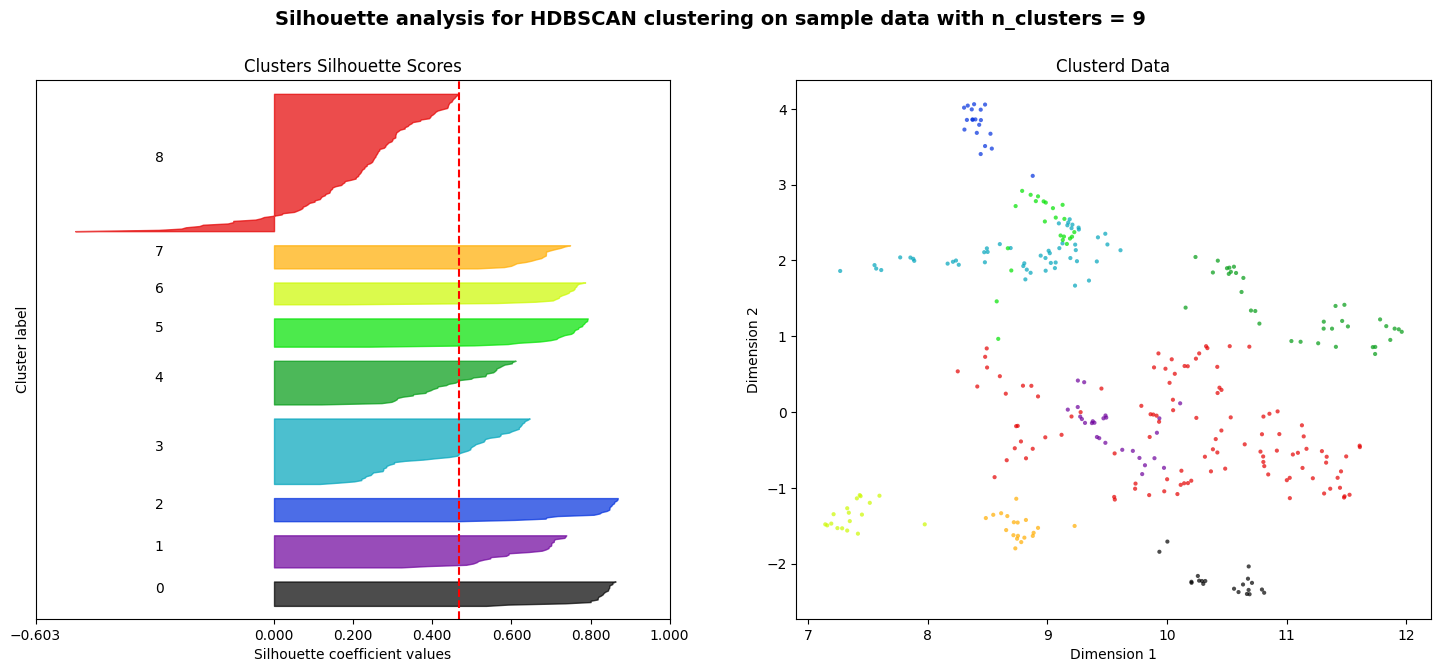

In [ ]:
silhouette_analysis(embeds, labels, "HDBSCAN")

In [ ]:
ce = ClustersEntities(raw_text, labels)

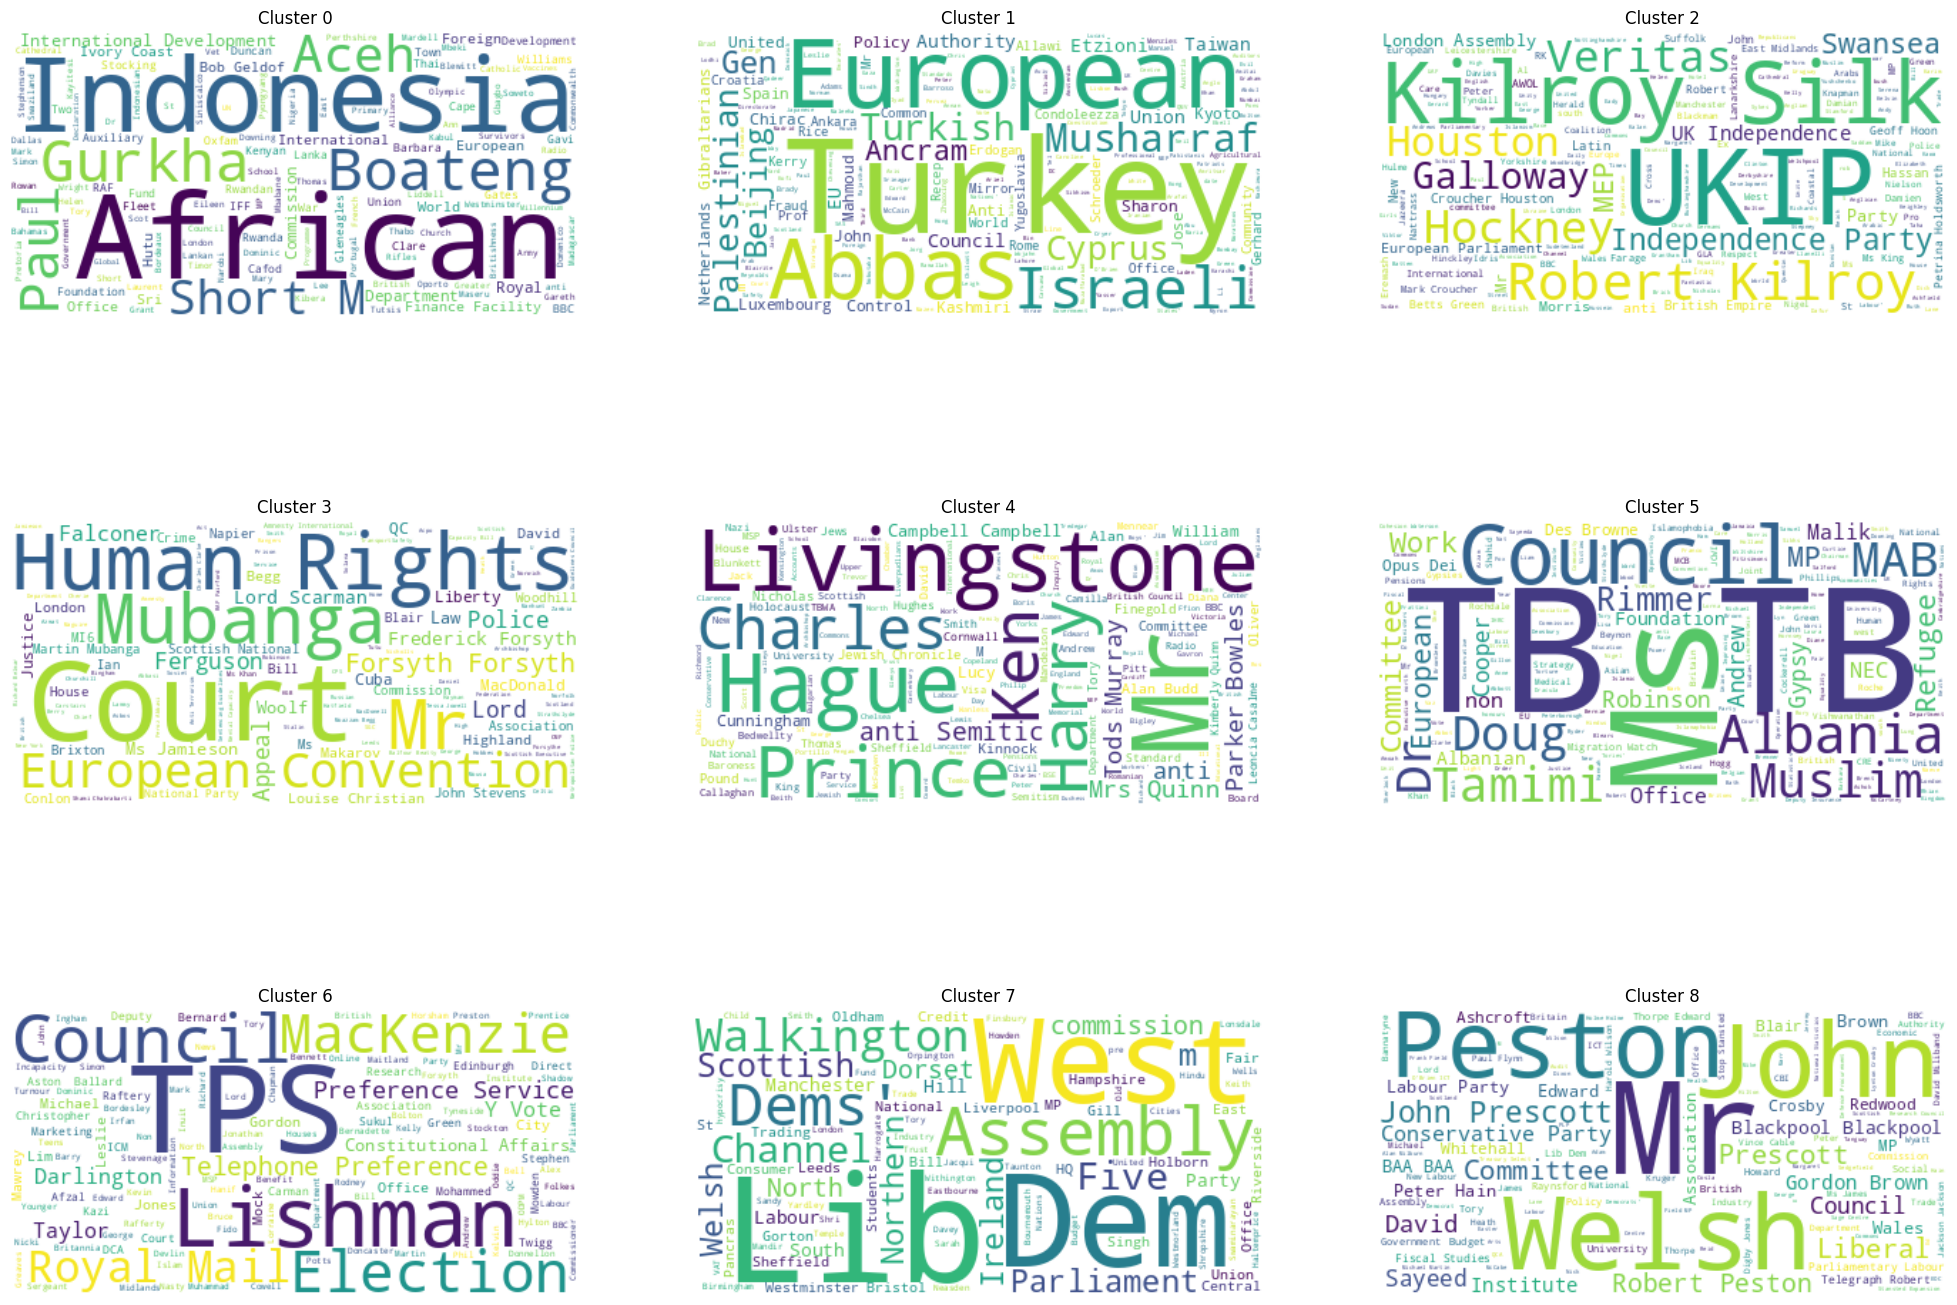

In [ ]:
ce.visualize_cluster(entity_labels = ["NORP", "PERSON", "ORG", "EVENT", "GPE"])

In [ ]:
cat_dict = {f"cluster_{k}":" ".join(set(v)) for k, v in ce.unique_label_ents.items()}

In [ ]:
prompt = f"""
Give these categories appropriate labels
{cat_dict}

Return a JSON
"""

In [ ]:
llm_cluster_annotation("deepseek/deepseek-r1-0528:free", "Chutes", prompt)

```json
{
  "cluster_0": "International Development and UK Policy",
  "cluster_1": "Global Politics and Diplomacy",
  "cluster_2": "British Nationalism and Euroscepticism",
  "cluster_3": "Security, Justice, and Human Rights",
  "cluster_4": "Royalty and UK Elite Society",
  "cluster_5": "Race, Religion, and Immigration",
  "cluster_6": "UK Local Politics and Media",
  "cluster_7": "UK Political Parties and Elections",
  "cluster_8": "Economic Policy and Government Administration"
}
```


In [ ]:
llm_cluster_annotation("deepseek/deepseek-r1-0528:free", "Targon", prompt)

```json
{
  "cluster_0": "International Development and Humanitarian Aid",
  "cluster_1": "Global Politics and Diplomacy",
  "cluster_2": "UK Politics and National Identity",
  "cluster_3": "Legal and Security Issues",
  "cluster_4": "British Monarchy and Political Figures",
  "cluster_5": "Social Issues and Minority Groups",
  "cluster_6": "Local and Regional Governance",
  "cluster_7": "Party Politics and Legislative Affairs",
  "cluster_8": "Economic Policy and Governance"
}
```


In [ ]:
clusterer

HDBSCAN(min_cluster_size=11, prediction_data=True)

In [ ]:
with open("/content/drive/MyDrive/bbc/output/politics_reducer.pkl", "rb") as f:
  politics_reducer = pickle.load(f)

In [ ]:
politics_reducer

UMAP(n_components=3, n_jobs=1, n_neighbors=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
politics_inference_object = {
    "dimension_reducer": politics_reducer,
    "clustering_algorithm": clusterer,
    "labels": {
        "0": "International Development and UK Policy",
        "1": "Global Politics and Diplomacy",
        "2": "British Nationalism and Euroscepticism",
        "3": "National Security, Counter-Terrorism, and Legal Systems",
        "4": "British Monarchy and Elite Societies",
        "5": "Social Issues and Minority Groups",
        "6": "Local and Regional Governance",
        "7": "UK Political Parties and Elections",
        "8": "Economic Policy and Government Administration"
    }
}

In [ ]:
with open("/content/drive/MyDrive/bbc/output/politics_inference_object.pkl", "wb") as f:
  pickle.dump(politics_inference_object, f)

# BUSINESS

In [ ]:
embeds, raw_text = get_category_embeddings(embedder, category = "business", n_dim = 3, batch_size = 50)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


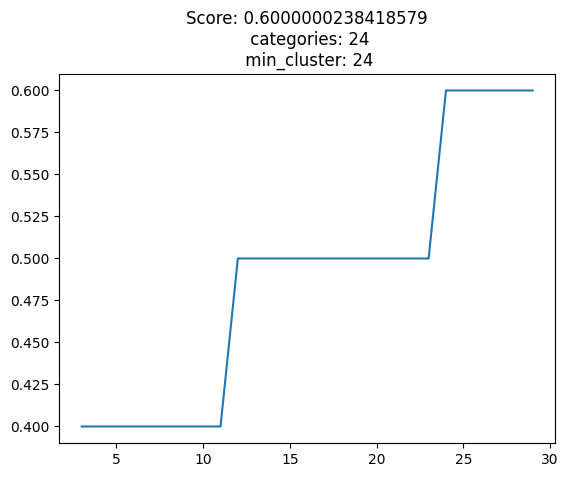

In [ ]:
cluster_analysis(embeds, range(3, 30))

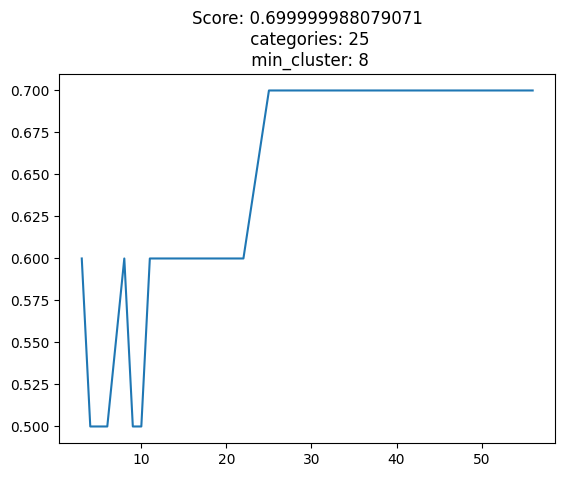

In [ ]:
cluster_analysis(embeds, range(3, 30), kmeans = False)

In [ ]:
kmeans = False
if kmeans:
  clusterer = KMeans(n_clusters = 11)
else:
  clusterer = hdbscan.HDBSCAN(min_cluster_size = 15, prediction_data = True)

In [ ]:
labels = clusterer.fit_predict(embeds)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
f"{round(len(labels[labels == -1]) * 100 / len(labels), 2)}%"

'38.73%'

In [ ]:
visualize_cluster_3D(embeds, labels, labels)

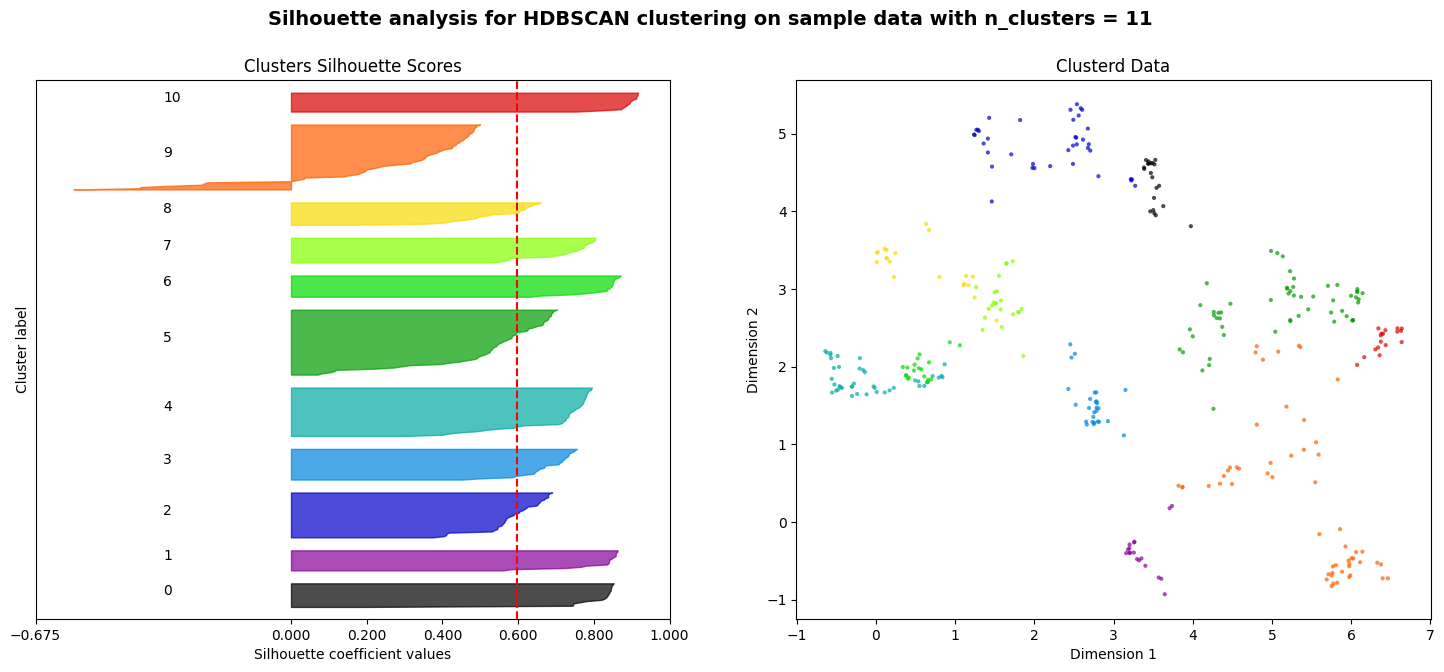

In [ ]:
silhouette_analysis(embeds, labels, "HDBSCAN")

In [ ]:
ce = ClustersEntities(raw_text, labels)

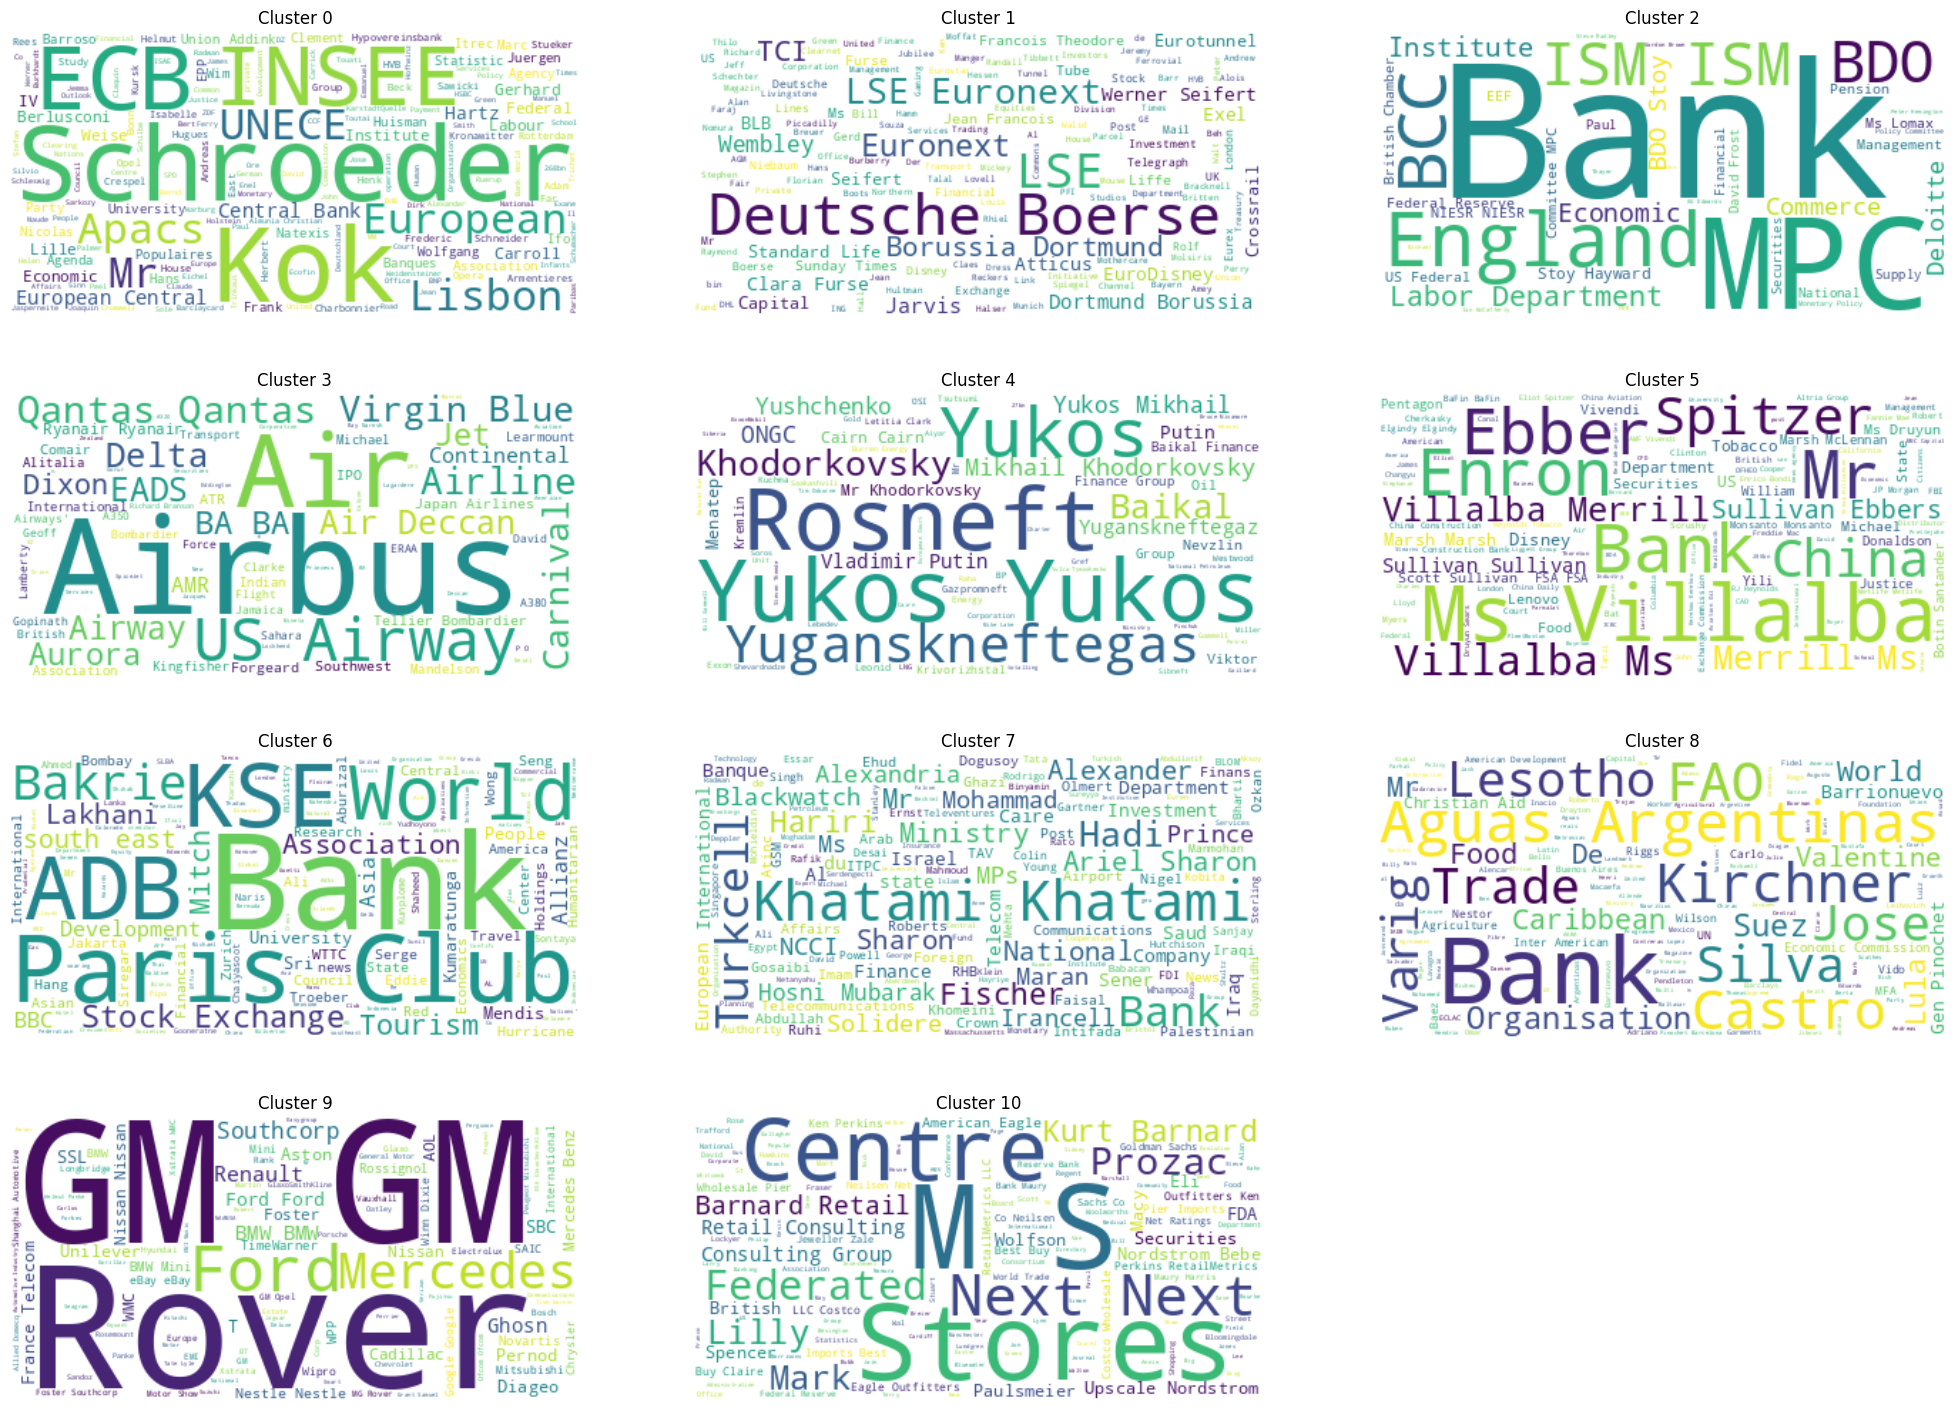

In [ ]:
ce.visualize_cluster(entity_labels = ["PERSON", "ORG", "EVENT", "PRODUCT", "FAC", "LOC"])

In [ ]:
def category_representative_sentence(category_docs: list):
  all_sentence = []
  all_score = []
  for doc in category_docs:
    doc_embeds = embedder.encode(doc).reshape(1, -1)
    max_score = 0
    doc_sentence = ""
    for sentence in doc.split("\n\n"):
      sentence_embeds = embedder.encode(sentence).reshape(1, -1)
      score = cosine_similarity(doc_embeds, sentence_embeds)
      if score > max_score:
        doc_sentence = sentence
        max_score = score
    all_sentence.append(doc_sentence)
    all_score.append(np.round(max_score, 2))
  return all_sentence, all_score

In [ ]:
def extract_nouns_verbs(category_docs: list):
  sentences, scores = category_representative_sentence(category_docs)
  all_words = set()
  for sentence in sentences:
    doc = nlp(sentence)
    for tok in doc:
      if tok.pos_ in ["NOUN", "VERB"]:
        all_words.add(tok.text)
  return all_words

In [ ]:
cat_dict = {f"cluster_{k}":" ".join(set(v)) for k, v in ce.unique_label_ents.items()}

In [ ]:
action_words = {k: extract_nouns_verbs(np.array(raw_text)[labels == k].tolist()) for k in range(11)}

In [ ]:
business_categories = {}
for i, k in enumerate(cat_dict):
  words = action_words[i].union(cat_dict[k].split())
  business_categories[k] = " ".join(words)

In [ ]:
prompt = f"""
Give these categories appropriate labels
{cat_dict}

Return a JSON
"""

In [ ]:
# llm_cluster_annotation("deepseek/deepseek-r1-0528:free", "Chutes", prompt)

```json
{
  "cluster_0": "European Economic and Political Figures",
  "cluster_1": "UK and European Business and Infrastructure",
  "cluster_2": "Global Financial and Economic Analysis",
  "cluster_3": "Aviation Industry and Airlines",
  "cluster_4": "Eastern European Energy and Politics",
  "cluster_5": "Corporate Scandals and Legal Affairs",
  "cluster_6": "Asian and Middle Eastern Development and Politics",
  "cluster_7": "Middle Eastern Politics and Telecom",
  "cluster_8": "Latin American Development and Politics",
  "cluster_9": "Global Automotive and Consumer Goods",
  "cluster_10": "Retail and Consumer Markets"
}
```

In [ ]:
prompt = f"""
Give these categories appropriate labels
{business_categories}

Return a JSON
"""

In [ ]:
llm_cluster_annotation("deepseek/deepseek-r1-0528:free", "Chutes", prompt)

```json
{
  "cluster_0": "Economic and Financial Trends",
  "cluster_1": "Corporate Acquisitions and Stock Market",
  "cluster_2": "Labor Market and Economic Analysis",
  "cluster_3": "Aviation and Aerospace Industry",
  "cluster_4": "Energy and Natural Resources",
  "cluster_5": "Corporate Scandals and Legal Issues",
  "cluster_6": "Natural Disasters and Humanitarian Aid",
  "cluster_7": "Telecommunications and Technology",
  "cluster_8": "International Trade and Politics",
  "cluster_9": "Automotive and Manufacturing Industry",
  "cluster_10": "Retail and Consumer Goods"
}
```


In [ ]:
pd.Series(labels).value_counts()

-1     213
 9      56
 5      56
 4      42
 2      39
 3      27
 7      22
 0      21
 8      20
 6      19
 1      18
 10     17
Name: count, dtype: int64

In [ ]:
with open("/content/drive/MyDrive/bbc/output/business_reducer.pkl", "rb") as f:
  business_reducer = pickle.load(f)

In [ ]:
business_inference_object = {
    "dimension_reducer": business_reducer,
    "clustering_algorithm": clusterer,
    "labels": {
        "0": "Economic and Financial Trends",
        "1": "Corporate Acquisitions and Stock Market",
        "2": "Labor Market and Economic Analysis",
        "3": "Aviation and Aerospace Industry",
        "4": "Energy and Natural Resources",
        "5": "Corporate Scandals and Legal Issues",
        "6": "Natural Disasters and Humanitarian Aid",
        "7": "Telecommunications and Technology",
        "8": "International Trade and Politics",
        "9": "Automotive and Manufacturing Industry",
        "10": "Retail and Consumer Goods"
        }
}

In [ ]:
with open("/content/drive/MyDrive/bbc/output/business_inference_object.pkl", "wb") as f:
  pickle.dump(business_inference_object, f)

# GLOBAL CATEGORY

In [ ]:
def data_loader(category: str, k: int = 100):
  train_data = dict()
  validation_data = dict()
  train_articles = random.sample(glob.glob(os.path.join(BASE_DIR, category) + "/*.txt"), k)
  for article in train_articles:
    with open(article, "r") as f:
      raw_text = f.read()
    train_data[os.path.basename(article)] = raw_text

  validation_articles = list(set(glob.glob(os.path.join(BASE_DIR, category) + "/*.txt")).difference(train_articles))
  for article in random.sample(validation_articles, k):
    with open(article, "r") as f:
      raw_text = f.read()
    validation_data[os.path.basename(article)] = raw_text

  return {
      "train": train_data,
      "validation": validation_data
  }

In [ ]:
train_data = []
train_labels = []
validation_data = []
validation_labels = []
for category in ["tech", "sport", "entertainment", "politics", "business"]:
  articles = data_loader(category)
  train_articles = articles["train"]
  validation_articles = articles["validation"]
  for article in train_articles:
    train_data.append(train_articles[article])
    train_labels.append(category)
  for article in validation_articles:
    validation_data.append(validation_articles[article])
    validation_labels.append(category)

In [ ]:
len(train_data), len(validation_data), len(train_labels), len(validation_labels)

(500, 500, 500, 500)

In [ ]:
def get_embeddings(model: SentenceTransformer, raw_data: list, batch_size: int = 50, save_file: str = "train_data") -> np.ndarray:
  embeddings = np.empty((0, model.get_sentence_embedding_dimension()))
  for i in tqdm.tqdm(range(0, len(raw_data), batch_size)):
    embeddings = np.concatenate([
        embeddings,
        model.encode(raw_data[i:i+batch_size])
    ])
  save_path = os.path.join("/content/drive/MyDrive/bbc/output/", f"{save_file}.npy")
  np.save(save_path, embeddings)
  return embeddings

In [ ]:
train_embeds = get_embeddings(embedder, train_data, batch_size = 50)

100%|██████████| 10/10 [14:03<00:00, 84.33s/it]


In [ ]:
dimension_reducer = umap.UMAP(n_components=3, n_neighbors=10, min_dist=0.1)

In [ ]:
reduced_train_embeds = dimension_reducer.fit_transform(train_embeds)

In [ ]:
reduced_train_embeds.shape

(500, 3)

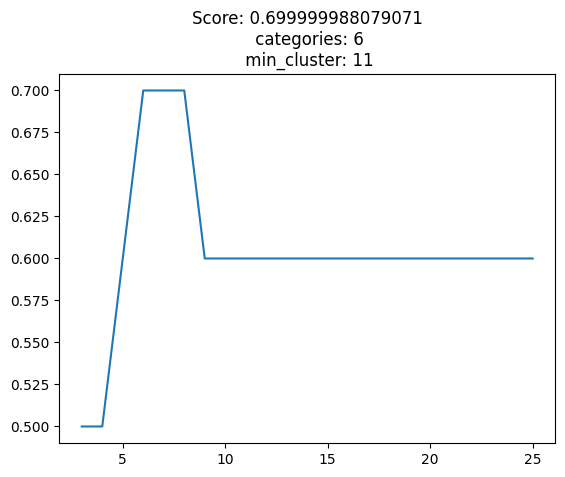

In [ ]:
cluster_analysis(reduced_train_embeds, range(3, 30), kmeans = False)

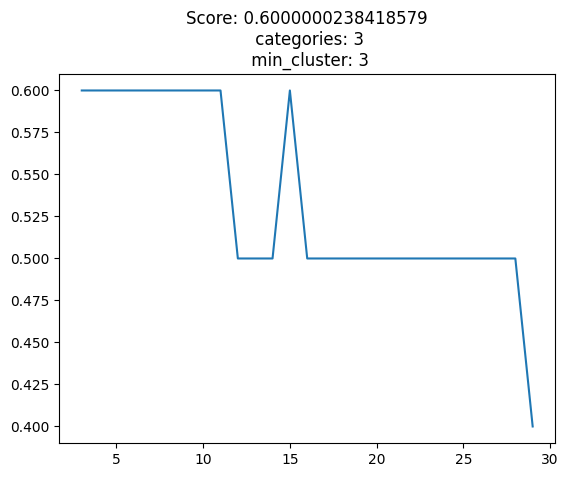

In [ ]:
cluster_analysis(reduced_train_embeds, range(3, 30))

In [ ]:
clusterer = KMeans(n_clusters = 5)

In [ ]:
labels = clusterer.fit_predict(reduced_train_embeds)

In [ ]:
visualize_cluster_3D(reduced_train_embeds, labels, labels)

# Archive Codes

In [ ]:
def sample_data(k = 10):
  data = dict()
  for category in ["tech", "sport", "politics", "business", "entertainment"]:
     for article in random.sample(glob.glob(os.path.join(BASE_DIR, category) + "/*.txt"), k):

      with open(article, "r") as f:
        raw_text = f.read()

      if category not in data:
        data[category] = dict()

      data[category][os.path.basename(article)] = {
          "raw_text": raw_text,
          "title": raw_text.split("\n\n")[0]
          }
  return data

In [ ]:
  data = sample_data()

In [ ]:
train_data = []
for cat in data:
  for article in data[cat]:
    train_data.append(data[cat][article]["raw_text"])

In [ ]:
def get_category_embeddings(*category):
  txt = []
  title = []

  for i in category:
    for article in data[i]:
      txt.append(data[i][article]["raw_text"])
      title.append(i + " " + data[i][article]["title"])

  category_embeddings = embedder.encode(txt)
  reduced_embeddings = umap.UMAP(n_components=3, n_neighbors=10, min_dist=0.1).fit_transform(category_embeddings)

  return reduced_embeddings, title

In [ ]:
embeds, title = get_category_embeddings("sport", "entertainment", "tech", "business", "politics")

In [ ]:
kmeans_cluster = KMeans(n_clusters = 5)
k_labels = kmeans_cluster.fit_predict(embeds)

In [ ]:
visualize_cluster_3D(embeds, k_labels, title)

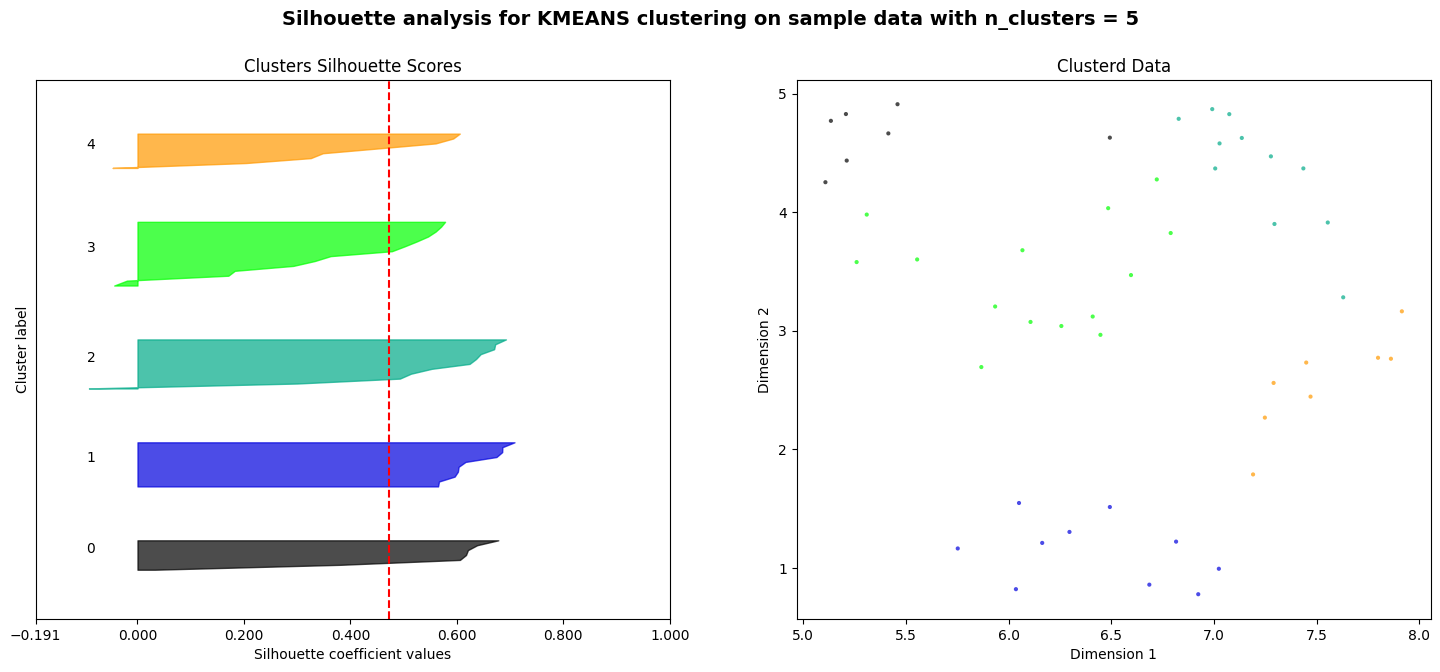

In [ ]:
silhouette_analysis(embeds, k_labels, "KMEANS")

In [ ]:
def get_cluster_raw_text(labels, cluster = 0):
  idx = np.arange(len(labels))[labels == cluster].tolist()
  raw_text = ""
  for i in idx:
    raw_text += train_data[i] + "\n\n"
  return raw_text

In [ ]:
txt = get_cluster_raw_text(k_labels, cluster = 2)

In [ ]:
keywords_and_scores = KeyBERT().extract_keywords(txt,
                                                 keyphrase_ngram_range=(2, 2), top_n=20)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
keywords_and_scores

[('glasgow flanker', 0.5524),
 ('ligaments scott', 0.5093),
 ('macleod ankle', 0.5011),
 ('flanker andrew', 0.4964),
 ('scotland row', 0.486),
 ('injury hodgson', 0.481),
 ('stuart joins', 0.474),
 ('scott macleod', 0.4729),
 ('premiership stuart', 0.4592),
 ('scott gray', 0.4461),
 ('england injury', 0.445),
 ('option glasgow', 0.4352),
 ('injury doubt', 0.4342),
 ('qualify scotland', 0.4266),
 ('league stuart', 0.4179),
 ('scott potential', 0.4167),
 ('flanker jason', 0.406),
 ('injury list', 0.403),
 ('scott right', 0.3967),
 ('recently flanker', 0.3939)]

In [ ]:
# ce.visualize_cluster(entity_labels = ["PERSON", "ORG", "EVENT"]) #SPORT
# ce.visualize_cluster(entity_labels = ["PRODUCT", "ORG", "EVENT"]) #tech
# ce.visualize_cluster(entity_labels = ["PERSON", "ORG", "EVENT"]) #entertainment
# ce.visualize_cluster(entity_labels = ["NORP", "PERSON", "ORG", "EVENT"]) #politics